# Week 6 Project Introduction - Data Pipeline

This week's project gives a brief overview into Data Engineering by extracting tweets from twitter and perform a Sentiment analysis on them. We separate the whole workflow in small managable parts where all are **connected to each other** and can be launched or stopped with a single command.

The **data** this week will be real-time tweets what we access using the **Twitter API**.

There are quite a few **new concepts** that we will cover this week:
- [Application Programming Interfaces (APIs)](https://spiced.space/stationary-sriracha/ds-course/chapters/project_pipeline/api/README.html)
- [Docker](https://spiced.space/stationary-sriracha/ds-course/chapters/project_pipeline/docker/README.html)/[Docker-Compose](https://spiced.space/stationary-sriracha/ds-course/chapters/project_pipeline/docker/compose.html)
- NoSQL Databases (we use [MongoDB](https://spiced.space/stationary-sriracha/ds-course/chapters/project_pipeline/mongodb/README.html))
- [ETL (Extract-Transform-Load](https://spiced.space/stationary-sriracha/ds-course/chapters/project_pipeline/etl/README.html)
- [Sentiment Analysis](https://spiced.space/stationary-sriracha/ds-course/chapters/project_pipeline/sentiment_analysis.html)

The animation below shows this week's workflow as an illustrated analogy:

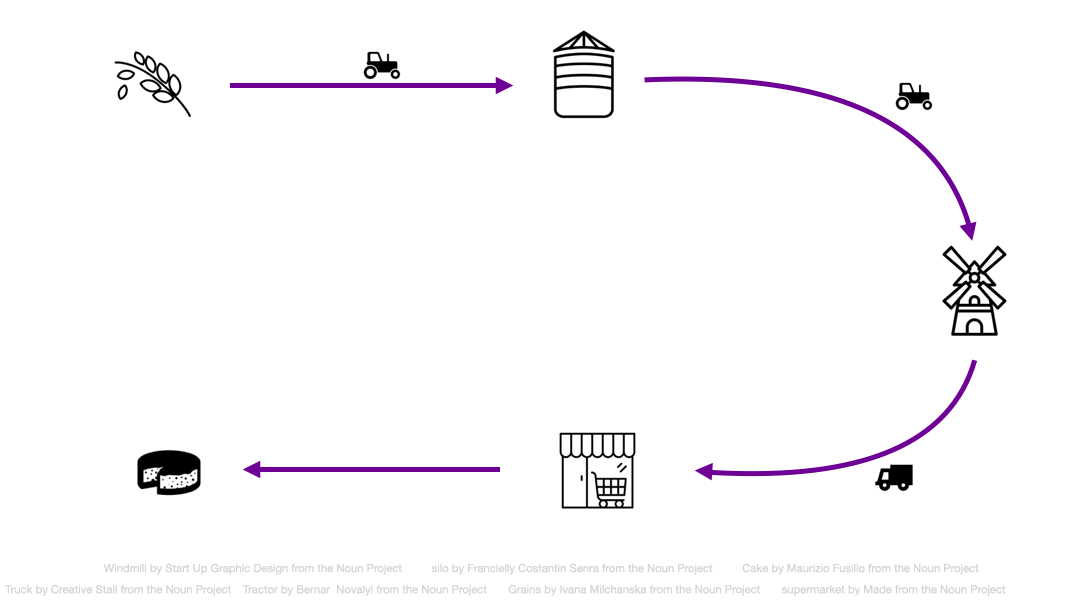

In [1]:
#Pipeline animation
from IPython.display import Image, display
display(Image(filename="intro_pipeline.gif", format='gif'))

# To run it again, run the cell again!

Manage and run and entire data stream / “pipeline”, where each component of the pipeline is its own, isolated [“microservice”](https://aws.amazon.com/microservices/) managed by Docker Compose.

In simpler terms: Run a complex, interconnected piece of software (composed of 5 individual moving parts) in such a way that all components run continuously and talk to each other, and the whole pipeline can be launched (and stopped) with a single command.

# API - Application Programming Interfaces

Why?
- APIs are the data source for the data pipeline we are building this week. 
- In general, APIs are a great data source.

What?

From the course materials:

- An API, short for Application Programming Interface, is a concept used to describe –essentially – a piece of intermediary software (the interface) that facilitates communication between 2 other pieces of software (the applications).
- This is a very general definition. When we talk about APIs, we mostly refer to Web APIs.
- API = website providing data in a format more machine-readable than HTML.
 - We still submit an HTTP request though, e.g. with the   library.
- [Rest](https://www.redhat.com/en/topics/api/what-is-a-rest-api#:~:text=A%20REST%20API%20(also%20known,by%20computer%20scientist%20Roy%20Fielding.) / RESTful APIs:
 - REST = representational state transfer.
 - They conform to particular architectural standards — software developers creating them, had to pay attention to certain things, and design them in certain way; it's a way of standardizing APIs some. "Best practices" for designing APIs.

### What makes a Web API better than scraping? 

- We still send HTTP `requests` but this time we get different data back!
- A Web API provides data in a **more machine-readable format** than HTML (mostly JSON) 
    - In week 4: we send an HTTP request, and get back HTML. 
    - Now: we send an HTTP request, get back JSON.
- With an API we know we are definitely allowed to access the data we are using, and on what terms
- For larger data providers (eg. Twitter) there are often helper libraries (+ documentation!) that make the process even easier. This week we will be using `tweepy`.

# Example of testing an API 

In [1]:
"""
Berlin public transport API
"""

import requests

BASE_URL = 'https://v5.vbb.transport.rest'

# find a station
name = 'moritzplatz'
url = f"{BASE_URL}/locations?poi=false&addresses=false&query={name}"
station_id = requests.get(url).json()[0]['id']

# look up departures
print('\nNext connections from U Moritzplatz:\n')

url = f'{BASE_URL}/stops/{station_id}/departures?duration={10}'

j = requests.get(url).json()

for e in j:
    print(e['plannedWhen'][11:-9], '  ', e['line']['name'], 'to',e['direction'])


Next connections from U Moritzplatz:

21:29    M29 to U Hermannplatz
21:33    M29 to Grunewald, Rathenauplatz
21:38    U8 to S+U Gesundbrunnen
21:39    M29 to U Hermannplatz
21:38    U8 to S+U Hermannstr.
21:43    U8 to S+U Wittenau
21:43    M29 to Grunewald, Roseneck
21:44    U8 to S+U Hermannstr.


In [2]:
for e in j:
    print(e)

{'tripId': '1|22919|0|86|19042022', 'stop': {'type': 'stop', 'id': '900000013101', 'name': 'U Moritzplatz', 'location': {'type': 'location', 'id': '900013101', 'latitude': 52.503737, 'longitude': 13.410944}, 'products': {'suburban': False, 'subway': True, 'tram': False, 'bus': True, 'ferry': False, 'express': False, 'regional': False}}, 'when': '2022-04-19T21:36:00+02:00', 'plannedWhen': '2022-04-19T21:29:00+02:00', 'delay': 420, 'platform': None, 'plannedPlatform': None, 'direction': 'U Hermannplatz', 'provenance': None, 'line': {'type': 'line', 'id': 'm29', 'fahrtNr': '43128', 'name': 'M29', 'public': True, 'adminCode': 'BVB', 'productName': 'Bus', 'mode': 'bus', 'product': 'bus', 'operator': {'type': 'operator', 'id': 'berliner-verkehrsbetriebe', 'name': 'Berliner Verkehrsbetriebe'}, 'symbol': 'M', 'nr': 29, 'metro': True, 'express': False, 'night': False}, 'remarks': [{'type': 'hint', 'code': 'OPERATOR', 'text': 'BVG'}, {'type': 'hint', 'code': 'bf', 'text': 'barrierefrei'}, {'id':

# Tweepy

In [3]:
#!pip install tweepy

In [4]:
# Connect to twitter API
import tweepy
import twitter_keys
client = tweepy.Client(bearer_token=twitter_keys.Bearer_Token)

### Look up a user by their user name

(For `user_fields` parameters check here https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/user

In [5]:
gavin = client.get_user(username='gavofyork',user_fields=['name','id','created_at'])
user = gavin.data
print(gavin)

Response(data=<User id=33962758 name=Gavin Wood username=gavofyork>, includes={}, errors=[], meta={})


We can get all the data from our user as a dictionary:

In [6]:
dict(user)

{'username': 'gavofyork',
 'created_at': datetime.datetime(2009, 4, 21, 16, 55, 10, tzinfo=datetime.timezone.utc),
 'id': 33962758,
 'name': 'Gavin Wood'}

... or get out individual pieces of information:

In [7]:
print(f'the user with name {user.name} and ID {user.id} created their twitter account on {user.created_at}')

the user with name Gavin Wood and ID 33962758 created their twitter account on 2009-04-21 16:55:10+00:00


### Look at a user's timeline
(for `tweet_fields` parameters check here https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet)

In [8]:
gavin_tweets = client.get_users_tweets(id=user.id, tweet_fields=['id','text','created_at'],max_results=100)
print(gavin_tweets.data)

[<Tweet id=1515037557037404168 text='@kusamanetwork ? https://t.co/8bK9mziXrF'>, <Tweet id=1514248566633644042 text='RT @Tether_to: #Tether USDt launches on @kusamanetwork\nRead more here: https://t.co/b2h3THRNbU\n https://t.co/BtJTpzO3oH'>, <Tweet id=1513428754000982019 text='Power to the builders ✊💪 Perhaps in the near future the new primitives for @Polkadot governance can be used here too.. https://t.co/CxEhUjAXua'>, <Tweet id=1513258366386192391 text='RT @DonnieBigBags: Community call will happen on the @MoonsamaNFT discord today at 4pm UTC: https://t.co/xrI3KCoQh6\n\nBut it will also happe…'>, <Tweet id=1508841455510425600 text="A nice writeup of @polkadot's/@kusamanetwork's XCMv2 by @quarkslab now published at https://t.co/iOpaOeKOFv Look out for another one on the upcoming XCMv3...">, <Tweet id=1507056763773853700 text="RT @alexeiZamyatin: Finally, it's live. \n\nYou can now mint trustless $kBTC on @KaruraNetwork and use it on @MoonriverNW and @KaruraNetwork…">, <Tweet id=150565

We can write the tweets to a text file:

In [17]:
for tweet in gavin_tweets.data:
    print(f"The user {user.name} at {tweet.created_at} wrote: {tweet.text}\n")
    file = open('tweets/gavin_tweets.txt',mode='a', encoding = 'utf8')
    file.write('\n\n'+tweet.text)
    file.close()

The user Gavin Wood at 2022-04-15 18:41:16+00:00 wrote: @kusamanetwork ? https://t.co/8bK9mziXrF

The user Gavin Wood at 2022-04-13 14:26:06+00:00 wrote: RT @Tether_to: #Tether USDt launches on @kusamanetwork
Read more here: https://t.co/b2h3THRNbU
 https://t.co/BtJTpzO3oH

The user Gavin Wood at 2022-04-11 08:08:27+00:00 wrote: Power to the builders ✊💪 Perhaps in the near future the new primitives for @Polkadot governance can be used here too.. https://t.co/CxEhUjAXua

The user Gavin Wood at 2022-04-10 20:51:24+00:00 wrote: RT @DonnieBigBags: Community call will happen on the @MoonsamaNFT discord today at 4pm UTC: https://t.co/xrI3KCoQh6

But it will also happe…

The user Gavin Wood at 2022-03-29 16:20:10+00:00 wrote: A nice writeup of @polkadot's/@kusamanetwork's XCMv2 by @quarkslab now published at https://t.co/iOpaOeKOFv Look out for another one on the upcoming XCMv3...

The user Gavin Wood at 2022-03-24 18:08:26+00:00 wrote: RT @alexeiZamyatin: Finally, it's live. 

You can now mi

### Using the `Paginator` object from `tweepy`: 
Getting more than 100 tweets at a time

#### Search recent tweets

In [9]:
# - means NOT
search_query = "#Ukraine"#testing_tweepy -is:retweet -is:reply -is:quote -has:links"
# -is : ignore the ...i.e. -is:retweet: ignore the retweets
# -has :  ignore the link in the tweet
#option to extract tweets of a particular language add `lang` parameter eg lang:de

cursor = tweepy.Paginator(
    method=client.search_recent_tweets,
    query=search_query,
    tweet_fields=['author_id', 'created_at', 'public_metrics'],
    user_fields=['username'],
).flatten(limit=200)

for tweet in cursor:
     print(tweet.data)


{'id': '1516506120034172931', 'text': 'RT @JoschKjK: dies war letzte Nacht\nnicht in der Ukraine 🇺🇦\nsondern in Gaza 🇵🇸\n\nwo ist eure Empörung?\nwo sind die Sanktionen?\n#Ukraine #Mar…', 'created_at': '2022-04-19T19:56:48.000Z', 'public_metrics': {'retweet_count': 25, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'author_id': '1125326156939526144'}
{'id': '1516506119937613824', 'text': 'RT @AyaIsleemEn: #Ukraine is urged  to defend its land by all means. Its fighters are champions. But when it comes to #Palestine, defending…', 'created_at': '2022-04-19T19:56:48.000Z', 'public_metrics': {'retweet_count': 122, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'author_id': '936345892654862341'}
{'id': '1516506117278515207', 'text': 'RT @JillDLawrence: What would we do if #Russia uses a tactical nuclear weapon in #Ukraine? Probably not use one ourselves, @djrothkopf conc…', 'created_at': '2022-04-19T19:56:48.000Z', 'public_metrics': {'retweet_count': 4, 'reply_count': 0, 'like

## References
Twitter API docs:
- https://docs.tweepy.org/en/stable/v2_pagination.html?highlight=paginator#tweepy.Paginator
- https://docs.tweepy.org/en/stable/client.html#tweepy.Client.get_users_tweets
- https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet
- https://docs.tweepy.org/en/stable/client.html#tweepy.Client.search_recent_tweets
- https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query


# Optional
To get tweets as continous streams 
check out the official github [link](https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Filtered-Stream/filtered_stream.py) by twitter developers